In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.30'

import jax
import jax.numpy as jnp

from functools import partial

import numpy as np

from sde4mbrl.nsde import ControlledSDE, create_sampling_fn, create_online_cost_sampling_fn
from sde4mbrl.apg import init_apg, apg

from tqdm.auto import tqdm
import time

import matplotlib.pyplot as plt

%matplotlib widget

# Magic IPython deepreloading...
%reload_ext autoreload
%autoreload 2
import builtins
from IPython.lib import deepreload
builtins.reload = deepreload.reload

%autoreload

In [2]:
# A simple linear stochastic system with known dynamics
class LinSDE(ControlledSDE):
    def __init__(self, params, name=None):
        # Define the params here if needed before initialization
        super().__init__(params, name)
    
    # The dynamics is known so the prior function is equal 
    # to the posterior function
    def prior_drift(self, t, x, u):
        return 3*x + u
    
    # We set the posterior function to be the same as the prior function
    posterior_drift = prior_drift
    
    # The noise in the dynamics
    def prior_diffusion(self, t, x):
        return jnp.array([4.])

# The known optimal policy
@jax.jit
def u_opt(t, x):
    return ((3*jnp.exp(8*t-8) - 7)*x / (1 + 3*jnp.exp(8*t-8)))

# COst function we want to optimize
def cost_fn(x, u):
    return jnp.sum(3.5 * jnp.square(x) + 0.5 * jnp.square(u))

# Terminal cost function
def cost_to_go(x):
    return 0.5 * jnp.sum(jnp.square(x))

In [3]:
import yaml

# Open the yaml file containing the configuration for the optimizer
yml_file = open('config_linreg.yaml')
yml_byte = yml_file.read()
m_config = yaml.load(yml_byte, yaml.SafeLoader)
yml_file.close()

print(m_config)

{'model': {'n_y': 1, 'n_u': 1, 'n_x': 1, 'num_particles': 100, 'num_particles_online_control': 1000, 'num_particles_learning_sde': 100, 'num_particles_valuefun_learning': 100, 'sde_solver': 'stratonovich_milstein'}, 'apg_mpc': {'stepsize': 10.0, 'max_iter': 10, 'moment_scale': None, 'beta_init': 0.25, 'tol': 0.001, 'linesearch': {'max_stepsize': 10.0, 'coef': 0.1, 'decrease_factor': 0.4, 'increase_factor': 1.2, 'reset_option': 'increase', 'maxls': 4}}, 'loss': {'kl': 1.0, 'logprob': 1.0, 'noise': 0, 'horizon': 10}, 'seed': 0, 'optimizer': [{'name': 'scale_by_adam'}, {'name': 'add_decayed_weights', 'params': {'weight_decay': 0.001}}, {'name': 'exponential_decay', 'scheduler': True, 'params': {'init_value': -0.01, 'transition_steps': 100000, 'decay_rate': 1.0}}, {'name': 'adaptive_grad_clip', 'params': {'clipping': 0.01}}], 'training': {'train_batch': 128, 'test_batch': 128, 'nepochs': 500, 'data_split_rate': 100, 'train_num_batch_eval': 15, 'patience': 15, 'display_losses': True, 'no_im

In [4]:
# More parameters for the control
stepsize = 0.01 # Integration step size
horizon = 50 # The number of steps for lookahead
ts = jnp.linspace(0, stepsize*horizon, horizon) # The different time indexes when learning

In [5]:
# Create a sampling function for forward propagation of the dynamics
# We set the number of particles to one since we need just one evaluation to step in the environment
_models = { k : v if k != 'num_particles'else 1 for k, v in m_config['model'].items()}
prior_params, sampling_fn = create_sampling_fn(_models, sde_constr=LinSDE, prior_sampling=True, seed=0)
# We do one-step ahead integration with only a single particle
jit_sampling = jax.jit(lambda x, u, rng_val: sampling_fn(prior_params, jnp.array([0, stepsize]), x, u, rng_val)[0,-1,:])

# Define a reset and step function in the environment (known SDE model)
def init_env(rng=None):
    return jnp.array([jnp.sqrt(2.)])
    # return jnp.array([0.5])

def step_env(xt, ut, rng):
    return jit_sampling(xt, ut, rng)

In [6]:
# We create a function to evaluate both the forward dynamics and the dynamics of the cost function
# The number of particles is specified in the yaml file
nn_params, cost_eval, proximal_fn, constraint_cost, construct_optim_params = \
    create_online_cost_sampling_fn(m_config['model'], cost_fn, terminal_cost=cost_to_go, sde_constr= LinSDE, seed=0)

# Initialize the parameters of the stochastic solver
@partial(jax.jit, static_argnums=(2,))
def initialize_apg(x0, rng, horizon):
    # Some random initialization -> close to zero but not exactly zero
    cost_xt = lambda u_params: cost_eval(nn_params, ts, x0, u_params, rng)[0]
    u0 = jnp.ones((horizon-1, 1)) * 1e-2
    opt_init = construct_optim_params(x0, u0)
    opt_state = init_apg(opt_init, cost_xt, m_config['apg_mpc'])
    return opt_state
    

# This function synthesize the optimal control given the current state of the system
# a random key generator and the past optimal solution
@jax.jit
def apg_mpc(xt, rng, past_solution):
    cost_xt = lambda u_params: cost_eval(nn_params, ts, xt, u_params, rng)[0]
    # For now, push the first solution to the back and start from this
    opt_init = jnp.concatenate((past_solution.yk[1:], past_solution.yk[-1:]))
    # Shift the solution so that it can be exploited
    opt_state = init_apg(opt_init, cost_xt, m_config['apg_mpc'],
                         momentum=past_solution.momentum,
                         stepsize=past_solution.avg_stepsize)

    new_opt_state = apg(opt_state, cost_xt, m_config['apg_mpc'], proximal_fn=proximal_fn)
    return new_opt_state

def extract_policy_apg(opt_state):
    return {'u' : opt_state.yk[0,:m_config['model']['n_u']], 'avg_linesearch': opt_state.avg_linesearch, 
            'num_steps' : opt_state.num_steps, 'grad_norm': opt_state.grad_sqr,
            'avg_stepsize': opt_state.avg_stepsize, 'cost0': opt_state.init_cost, 'costT': opt_state.opt_cost }

In [7]:
def play_policy(num_iteration, rng, opt_mpc, extract_policy, init_opt):
    # First split
    rng, init_rng = jax.random.split(rng)
    
    # Initialize the state in the environment
    state0 = init_env(init_rng)
    
    # Extract the initial state of the solver
    opt_state = init_opt(state0, init_rng, horizon)
    feats = extract_policy(opt_state)
    tqdm.write(' | '.join([ '{} : {:.3f}'.format(k,v) for k, v in feats.items() if k != 'u']))
    
    # Store the solution of the problem
    sol = {'state': [state0], 't': [jnp.array(0.) ]}
    
    # Iterate through the number steps in the environment
    for _ in tqdm(range(num_iteration)):
        rng, c_rng = jax.random.split(rng)
        
        # Measure the time spent in solving the problem
        curr_time = time.time()
        opt_state = opt_mpc(state0, c_rng, opt_state)
        # Block until ready
        if hasattr(opt_state, 'yk'):
            opt_state.yk.block_until_ready()
        else:
            opt_state.block_until_ready()
        elapsed_time = time.time() - curr_time
        
        # Extract the interesting features from the optimizer state
        feats = extract_policy(opt_state)
        feats['time'] = elapsed_time
        tqdm.write(' | '.join([ '{} : {:.3f}'.format(k,v) for k, v in feats.items() if k != 'u']))
        
        # Store the feature from the current optimization step
        for k, v in feats.items():
            if k not in sol:
                sol[k] = []
            sol[k].append(v)
        
        # Step in the environment to get the next state
        rng, c_rng = jax.random.split(rng)
        state0 = step_env(state0, feats['u'], c_rng)
        sol['state'].append(state0)
        sol['t'].append(sol['t'][-1]+stepsize)
    return sol

In [8]:
m_rng = jax.random.PRNGKey(0)
apg_opt_sol = play_policy(100, m_rng, apg_mpc, extract_policy_apg, initialize_apg)

avg_linesearch : 1.000 | num_steps : 1.000 | grad_norm : 4.708 | avg_stepsize : 10.000 | cost0 : 86.889 | costT : 86.889


  0%|          | 0/100 [00:00<?, ?it/s]

avg_linesearch : 1.000 | num_steps : 4.000 | grad_norm : 0.001 | avg_stepsize : 10.000 | cost0 : 87.485 | costT : 54.482 | time : 0.874
avg_linesearch : 1.000 | num_steps : 3.000 | grad_norm : 0.000 | avg_stepsize : 10.000 | cost0 : 59.818 | costT : 53.172 | time : 0.008
avg_linesearch : 1.000 | num_steps : 3.000 | grad_norm : 0.000 | avg_stepsize : 10.000 | cost0 : 53.034 | costT : 52.618 | time : 0.008
avg_linesearch : 1.000 | num_steps : 3.000 | grad_norm : 0.000 | avg_stepsize : 10.000 | cost0 : 48.988 | costT : 48.359 | time : 0.008
avg_linesearch : 1.000 | num_steps : 3.000 | grad_norm : 0.000 | avg_stepsize : 10.000 | cost0 : 52.943 | costT : 52.623 | time : 0.008
avg_linesearch : 1.000 | num_steps : 3.000 | grad_norm : 0.000 | avg_stepsize : 10.000 | cost0 : 48.586 | costT : 48.481 | time : 0.008
avg_linesearch : 1.000 | num_steps : 3.000 | grad_norm : 0.000 | avg_stepsize : 10.000 | cost0 : 50.006 | costT : 49.936 | time : 0.008
avg_linesearch : 1.000 | num_steps : 2.000 | gra

In [9]:
# Solve the problem with the optimal control solution
opt_traj = play_policy(100, m_rng, lambda xt, rng, past_solution: u_opt(0.,xt) , lambda opt: {'u' : opt}, lambda x, rng, h: None)

  0%|          | 0/100 [00:00<?, ?it/s]

time : 0.066
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000
time : 0.000

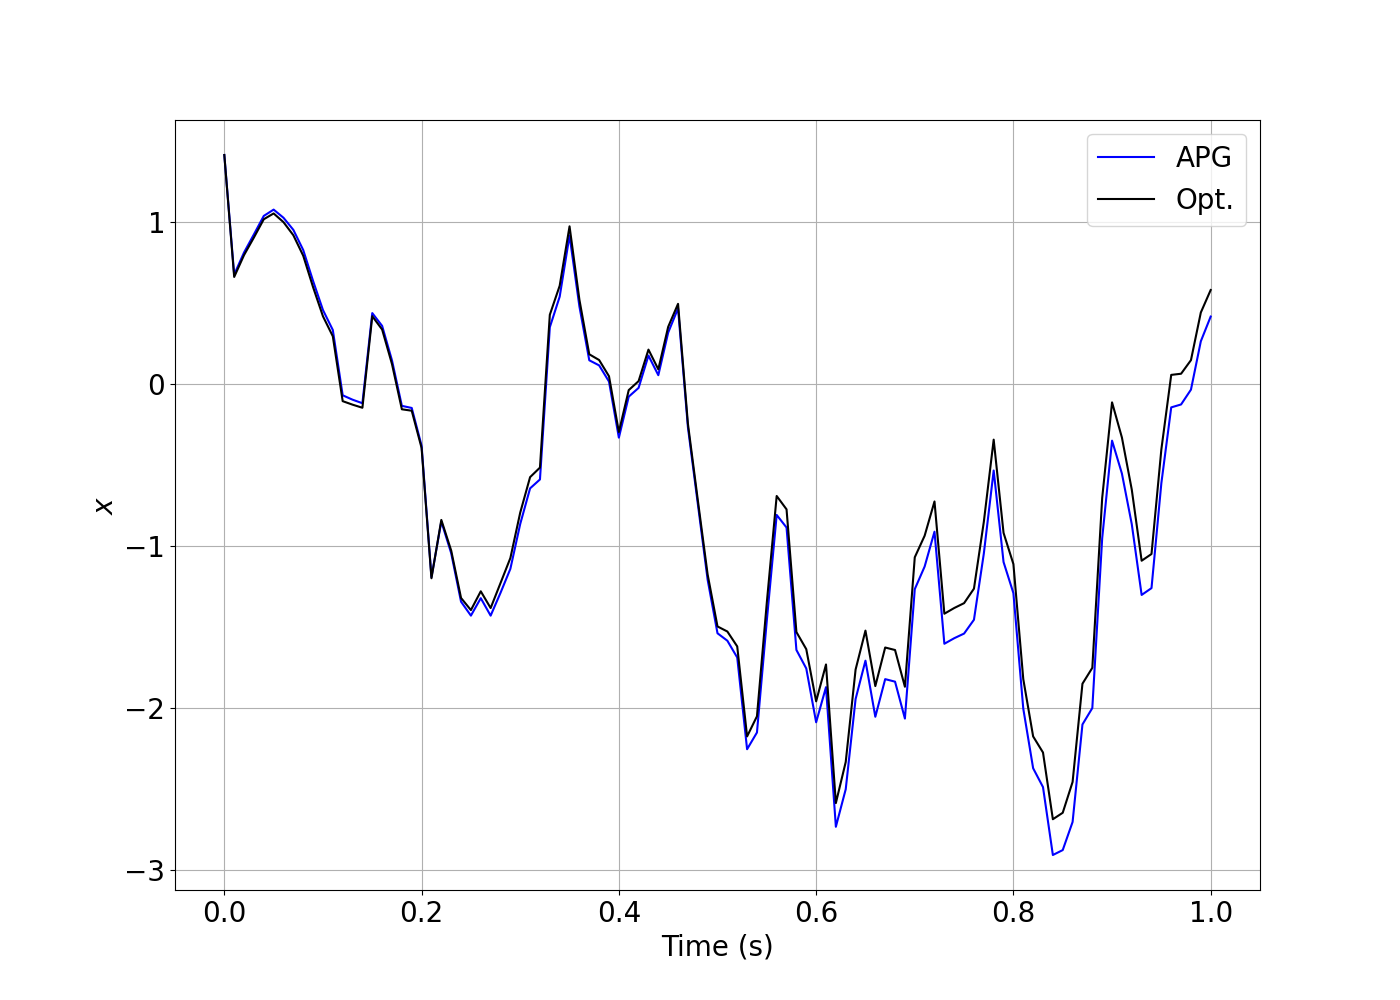

In [10]:
# Set the font size in the problem
plt.rcParams.update({'font.size': 20})

# Do some plotting
fig, ax = plt.subplots(figsize=(14, 10))
plt.plot(apg_opt_sol['t'], apg_opt_sol['state'], label='APG', color='blue')
plt.plot(opt_traj['t'], opt_traj['state'], label='Opt.', color='black')
plt.xlabel('Time (s)')
plt.ylabel('$x$')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
{'u' : opt_state.yk[:2,:m_config['model']['n_u']], 'avg_linesearch': opt_state.avg_linesearch, 
            'num_steps' : opt_state.num_steps, 'grad_norm': opt_state.grad_sqr,
            'avg_stepsize': opt_state.avg_stepsize, 'cost0': opt_state.init_cost, 'costT': opt_state.opt_cost }

In [ ]:
# Plot the soluion of the problem

In [ ]:
# # Use ADAM stochastic solver for comparison with the APG solver
# import optax

# # Initialize the state of the solver
# def initialize_adam(x0, rng, horizon):
#     optimizer = 
#     u0 = jnp.ones((horizon, 1)) * 1e-2
#     opt_init = construct_opt_params(x0, u0)
#     opt_state = optimizer.init(opt_init)
#     return optimizer, opt_state

# # Function to solve the MPC
# @jax.jit
# def adam_mpc(xt, rng, past_solution):
#     cost_xt = lambda u_params: cost_eval(nn_params, ts, xt, u_params, rng)[0]
#     loss_value, grads = jax.value_and_grad(cost_xt)(past_solution)
#     updates, opt_state = optimizer.update(grads, opt_state, params)
#     past_solution = optax.apply_updates(params, updates)
#     return past_solution, opt_state, loss_value

# optimizer = optax.adam(learning_rate=0.5)

# def extract_policy_adam(opt_state):
#     return opt_state